In [1]:
# Import
import pandas as pd
from finta import TA as ta
from pandas.tseries.offsets import DateOffset
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from pathlib import Path
from sklearn.neighbors import KNeighborsClassifier
import sqlalchemy as sql
from sklearn.ensemble import RandomForestClassifier

import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier


# Setting these options will allow for reviewing more of the DataFrames
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 2000)
pd.set_option('display.width', 1000)


In [2]:
tickers = ["BTC","LTC","ETH","ADA","THETA"]
closing_prices_df = pd.DataFrame()
for ticker in tickers:

    ticker1 = ticker
    ticker2 = "USDT"
    
    pair= "{}{}".format(ticker1,ticker2)
    dataframe_name = "df_{}".format(pair)
    start="2019.1.1"
    end = "2022.4.1"
    filepath = "Resources/{}_{}_to_{}.csv".format(pair,start,end)
    dataframe_name = pd.read_csv(Path(filepath), index_col= "Date", parse_dates= True, infer_datetime_format = True)
    if pair == "BTCUSDT":
        df_BTCUSDT = dataframe_name
    elif pair == "LTCUSDT":
        df_LTCUSDT = dataframe_name
    elif pair == "ETHUSDT":
        df_ETHUSDT = dataframe_name
    elif pair == "ADAUSDT":
        df_ADAUSDT = dataframe_name
    elif pair == "THETAUSDT":
        df_THETAUSDT = dataframe_name

    closing_prices_df[pair] = dataframe_name["Close"]
    #display(dataframe_name.head())
    #display(dataframe_name.tail())

In [3]:
#Determine altcoin correlation to BTC.
#Take price data and see if we have a positive or negitive correlation.
display(closing_prices_df.dropna().head())
close_matrix = closing_prices_df.corr()
print(close_matrix)


,BTCUSDT,LTCUSDT,ETHUSDT,ADAUSDT,THETAUSDT
Date,,,,,
2019-04-10 04:00:00,5188.11,87.65,178.70,0.08538,0.12465
2019-04-10 05:00:00,5213.77,88.20,180.12,0.08611,0.12500
2019-04-10 06:00:00,5213.89,88.34,180.45,0.08607,0.12401
2019-04-10 07:00:00,5199.97,87.60,179.08,0.08566,0.12350
2019-04-10 08:00:00,5209.96,87.89,179.45,0.08585,0.12622


            BTCUSDT   LTCUSDT   ETHUSDT   ADAUSDT  THETAUSDT
BTCUSDT    1.000000  0.896537  0.927456  0.890605   0.883011
LTCUSDT    0.896537  1.000000  0.807577  0.808970   0.878418
ETHUSDT    0.927456  0.807577  1.000000  0.929424   0.799544
ADAUSDT    0.890605  0.808970  0.929424  1.000000   0.849501
THETAUSDT  0.883011  0.878418  0.799544  0.849501   1.000000


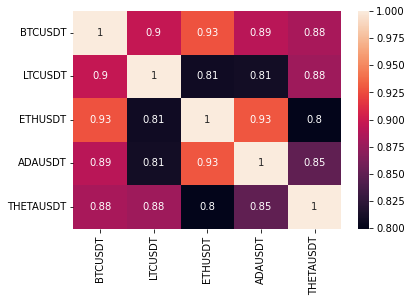

In [4]:
#Create a heat map of the correlation.
sn.heatmap(close_matrix, annot=True)
plt.show()

In [5]:
def appendData(maindf, dataarray, namesarray=None):
    if namesarray==None:
        return maindf.join(pd.DataFrame(dataarray), how='outer')
    return maindf.join(pd.DataFrame(dataarray,columns=namesarray), how='outer')

In [6]:
## Relative Strenght Index is displayed as an oscillator having a range from 0-100, the traditional usage is that anything
## above 70 is an indication of being overbought, where as anything below 30 is being oversold
df_BTCUSDT = appendData(df_BTCUSDT,ta.RSI(df_BTCUSDT))

## stochastic oscillator is an indicator that measures momentum, by comparing a securities closing price over a range
## of time. It takes a moving average of that range and generates an overbought or oversold signal utilizing a 0-100 
## range. The stochastic oscilattor uses a 14 day period, it uses the following to caculate:
## The most recent closing price
## The lowest price traded of the 14 previous trading sessions
## The highest price traded during the same 14-day period
## The current value of the stochastic indicator
df_BTCUSDT = appendData(df_BTCUSDT,ta.STOCH(df_BTCUSDT))

## Average directional index works with the next indicator, directional movement index, ADX is used to observe the strenght of DMI,
## when ADX is above around 25 the trend has strenght and when ADX is below 25 ADX is weak. The trend is found in DMI when DI+ is above
## DI- it is seen as upward pressure and when DI- is above DI+ is it negative pressure.
df_BTCUSDT = appendData(df_BTCUSDT,ta.ADX(df_BTCUSDT))
## DMI (Added to aid in interpreting ADX)
df_BTCUSDT = appendData(df_BTCUSDT,ta.DMI(df_BTCUSDT, 14))
## Awesome
## MACD is caculated by taking 26 period EMA and subtracting it by the 12 period EMA which results in MACD signal line
## MACD signal is triggered when the MACD line crosses over or under the MACD signal line, when it crosses over it is
## a buy signal and when it crosses under it is a sell signal
df_BTCUSDT = appendData(df_BTCUSDT,ta.MACD(df_BTCUSDT)).rename(columns={"SIGNAL": "MACD SIGNAL"})

## SMA, EMA
## SMA caculates the number of averages of a range of prices, in our model we use sma for 5, 10, 20, 30, 50, 100, 200
## EMA is similar to the SMA the main difference is that it gives more weight to the recent price data
## in our model we use sma and ema for 5, 10, 20, 30, 50, 100, 200
sma_ema_averages = [5, 10, 20, 30, 50, 100, 200]
for i in sma_ema_averages:
    df_BTCUSDT = appendData(df_BTCUSDT,ta.SMA(df_BTCUSDT, i))
    df_BTCUSDT = appendData(df_BTCUSDT,ta.EMA(df_BTCUSDT, i))
## BBANDS
## Bollinger bands are comprised of three lines the upper, middle and lower, the middle represents the moving average, and the upper and lower and set by the stanardard deviation
## and are positioned below and above the moving average
df_BTCUSDT = appendData(df_BTCUSDT,ta.BBANDS(df_BTCUSDT))



In [7]:
database_connection_string = 'sqlite:///'
engine = sql.create_engine(database_connection_string, echo=True)
sql_statement = """
CREATE TABLE crypto_outcome (
  column_name BLOB,
  _0_precision BLOB,
  _1_precision BLOB,
  _0_recall BLOB,
  _1_recall BLOB,
  _0_f1 BLOB,
  _1_f1 BLOB,
  _0_support BLOB,
  _1_support BLOB,
  _accuracy BLOB
  )
"""
result = engine.execute(sql_statement)

2022-04-13 18:12:41,207 INFO sqlalchemy.engine.Engine 
CREATE TABLE crypto_outcome (
  column_name BLOB,
  _0_precision BLOB,
  _1_precision BLOB,
  _0_recall BLOB,
  _1_recall BLOB,
  _0_f1 BLOB,
  _1_f1 BLOB,
  _0_support BLOB,
  _1_support BLOB,
  _accuracy BLOB
  )

2022-04-13 18:12:41,208 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-04-13 18:12:41,209 INFO sqlalchemy.engine.Engine COMMIT


In [16]:
models_list = [SVC(), RandomForestClassifier(), AdaBoostClassifier()] #KNeighborsClassifier(n_neighbors=3),
percent_threshold = .005
investment_amount = 10000
training_length = 18        


for m in models_list:
    model = m
    i = 15
    i_end = 30
    while i <= i_end:
        column_name = str(m) + str(i) + "_period_return"
        df_BTCUSDT[column_name] = df_BTCUSDT["Close"].pct_change(periods=-i)

        # Initialize the new `Signal` column
        signal_column_name_training = str(m) + str(i) + "_signal"
        df_BTCUSDT[signal_column_name_training] = 0.0
        # Generate signal to buy stock long
        df_BTCUSDT.loc[(df_BTCUSDT[column_name] >= (percent_threshold)), signal_column_name_training] = 1
        # Drop all NaN values from the DataFrame
        df_BTCUSDT = df_BTCUSDT.dropna()
        y = df_BTCUSDT[signal_column_name_training]
        # set up X for ml 
        X = df_BTCUSDT[['14 period RSI', '14 period STOCH %K', '14 period ADX.', 'DI+', 'DI-', 'MACD', 'MACD SIGNAL', '5 period SMA', '5 period EMA', '10 period SMA', '10 period EMA', '20 period SMA', '20 period EMA', '30 period SMA', '30 period EMA', '50 period SMA', '50 period EMA', '100 period SMA', '100 period EMA', '200 period SMA', '200 period EMA', 'BB_UPPER', 'BB_MIDDLE', 'BB_LOWER']].shift().dropna().copy()
        y_count = y.value_counts()
        training_begin = X.index.min()
        # Use the following code to select the ending period for the training data: `training_end = X.index.min() + DateOffset(months=3)`
        training_end = X.index.min() + DateOffset(months=training_length)
        # Generate the X_train and y_train DataFrames using loc to select the rows from `training_begin` up to `training_end`
        # Hint: Use `loc[training_begin:training_end]` for X_train and y_train
        X_train = X.loc[training_begin:training_end]
        y_train = y.loc[training_begin:training_end]

        # Generate the X_test and y_test DataFrames using loc to select from `training_end` to the last row in the DataFrame.
        # Hint: Use `loc[training_end:]` for X_test and y_test
        X_test = X.loc[training_end:]
        y_test = y.loc[training_end:]

        # Use StandardScaler to scale the X_train and X_test data.
        scaler = StandardScaler()
        X_scaler = scaler.fit(X_train)
        X_train_scaled = X_scaler.transform(X_train)
        X_test_scaled = X_scaler.transform(X_test)

        # Fit the model to the data using X_train_scaled and y_train
        model = model.fit(X_train_scaled, y_train)

        # Use the trained model to predict the trading signals for the training data.
        training_signal_predictions = model.predict(X_train_scaled)

        # Evaluate the model using a classification report
        training_report_train = classification_report(y_train, training_signal_predictions)
        #print(column_name)
        #print("Training Report")
        #print(training_report_train)

        # Use the trained model to predict the trading signals for the testing data.
        testing_signal_predictions = model.predict(X_test_scaled)
        predictions_df = pd.DataFrame(index=X_test.index)
        signal_column_name_predictions = str(m) + str(i) + "_signal" + "_predictions"
        predictions_df[signal_column_name_predictions] = 0.0
        predictions_df[signal_column_name_predictions] = testing_signal_predictions

        # Evaluate the model's ability to predict the trading signal for the testing data using a classification report
        #training_report_test = classification_report(y_test, testing_signal_predictions)

        reportdf = pd.DataFrame(classification_report(y_test, testing_signal_predictions, output_dict=True)).transpose()
        
        engine.execute("INSERT INTO crypto_outcome VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?,?)", (column_name, reportdf['precision'][0], reportdf['precision'][1], reportdf['recall'][0], reportdf['recall'][1], reportdf['f1-score'][0], reportdf['f1-score'][1],reportdf['support'][0], reportdf['support'][1], reportdf['precision'][2]))
       
       
        i+=1
    
sql_query = """
SELECT *
FROM crypto_outcome
"""
outcome = pd.read_sql_query(sql_query, engine, index_col='column_name')
outcome


2022-04-13 18:23:48,349 INFO sqlalchemy.engine.Engine INSERT INTO crypto_outcome VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?,?)
2022-04-13 18:23:48,349 INFO sqlalchemy.engine.Engine [raw sql] ('SVC()15_period_return', 0.6311841685285668, 0.2861736334405145, 0.8990679699931803, 0.07151466452390519, 0.7416783872480075, 0.11443265830922533, 8798.0, 4978.0, 0.6000290360046457)
2022-04-13 18:23:48,350 INFO sqlalchemy.engine.Engine COMMIT
2022-04-13 18:24:22,814 INFO sqlalchemy.engine.Engine INSERT INTO crypto_outcome VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?,?)
2022-04-13 18:24:22,815 INFO sqlalchemy.engine.Engine [raw sql] ('SVC()16_period_return', 0.6274021066173514, 0.2781557067271353, 0.8909568394610642, 0.07357057177129149, 0.7363057324840764, 0.11636363636363636, 8758.0, 5002.0, 0.5938226744186047)
2022-04-13 18:24:22,816 INFO sqlalchemy.engine.Engine COMMIT
2022-04-13 18:24:57,163 INFO sqlalchemy.engine.Engine INSERT INTO crypto_outcome VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?,?)
2022-04-13 18:24:57,163 INFO

,_0_precision,_1_precision,_0_recall,_1_recall,_0_f1,_1_f1,_0_support,_1_support,_accuracy
column_name,,,,,,,,,
SVC()5_period_return,0.987417,0.000000,1.000000,0.000000,0.993668,0.000000,19225.0,245.0,0.987417
SVC()6_period_return,0.984330,0.000000,1.000000,0.000000,0.992103,0.000000,19159.0,305.0,0.984330
SVC()7_period_return,0.980264,0.000000,1.000000,0.000000,0.990034,0.000000,19073.0,384.0,0.980264
SVC()8_period_return,0.977274,0.000000,1.000000,0.000000,0.988506,0.000000,19007.0,442.0,0.977274
SVC()9_period_return,0.973148,0.000000,1.000000,0.000000,0.986391,0.000000,18918.0,522.0,0.973148
SVC()10_period_return,0.969686,0.000000,1.000000,0.000000,0.984610,0.000000,18841.0,589.0,0.969686
SVC()11_period_return,0.966505,0.000000,0.999307,0.000000,0.982633,0.000000,18769.0,650.0,0.965858
SVC()10_period_return,0.758122,0.184549,0.974206,0.018435,0.852687,0.033522,14732.0,4665.0,0.744342
SVC()11_period_return,0.749827,0.181347,0.967481,0.021830,0.844861,0.038968,14576.0,4810.0,0.732848


In [19]:
outcome_filtered = outcome[outcome["_1_f1"] > 0.55]
# outcome_filtered = outcome_filtered[outcome_filtered["_1_precision"] > 0.50]
#  #   _0_precision	_1_precision	_0_recall	_1_recall	_0_f1	_1_f1	_0_support	_1_support	_accuracy

outcome_filtered

,_0_precision,_1_precision,_0_recall,_1_recall,_0_f1,_1_f1,_0_support,_1_support,_accuracy
column_name,,,,,,,,,
SVC()23_period_return,0.775839,0.391756,0.135458,0.934330,0.230646,0.552045,8534.0,5086.0,0.433774
SVC()24_period_return,0.766621,0.394819,0.133475,0.932943,0.227364,0.554834,8466.0,5130.0,0.435128
SVC()25_period_return,0.759545,0.392863,0.133932,0.929663,0.227711,0.552322,8467.0,5104.0,0.433203
SVC()26_period_return,0.774806,0.395084,0.130528,0.937378,0.223417,0.555878,8435.0,5110.0,0.434921
SVC()27_period_return,0.771841,0.393472,0.126839,0.937917,0.217874,0.554375,8428.0,5090.0,0.432238
SVC()28_period_return,0.782861,0.394535,0.128150,0.941119,0.220247,0.555989,8412.0,5078.0,0.434173
SVC()29_period_return,0.769874,0.396441,0.132010,0.935269,0.225375,0.556847,8363.0,5098.0,0.436223
SVC()30_period_return,0.780105,0.397222,0.125165,0.942330,0.215719,0.558865,8333.0,5098.0,0.435336
RandomForestClassifier()29_period_return,0.768603,0.388949,0.103558,0.948192,0.182523,0.551622,8179.0,4922.0,0.420884


In [20]:
predictions_df.tail()

,AdaBoostClassifier()30_signal_predictions
Date,
2021-12-21 12:00:00,1.0
2021-12-21 13:00:00,1.0
2021-12-21 14:00:00,1.0
2021-12-21 15:00:00,1.0
2021-12-21 16:00:00,1.0


In [34]:
models_list = [SVC()]
percent_threshold = .005
investment_amount = 10000
training_length = 18        


for m in models_list:
    model = m
    i = 29
    i_end = 30
    while i <= i_end:
        column_name = str(m) + str(i) + "_period_return"
        df_BTCUSDT[column_name] = df_BTCUSDT["Close"].pct_change(periods=-i)

        # Initialize the new `Signal` column
        signal_column_name_training = str(m) + str(i) + "_signal"
        df_BTCUSDT[signal_column_name_training] = 0.0
        # Generate signal to buy stock long
        df_BTCUSDT.loc[(df_BTCUSDT[column_name] >= (percent_threshold)), signal_column_name_training] = 1
        # Drop all NaN values from the DataFrame
        df_BTCUSDT = df_BTCUSDT.dropna()
        y = df_BTCUSDT[signal_column_name_training]
        # set up X for ml 
        X = df_BTCUSDT[['14 period RSI', '14 period STOCH %K', '14 period ADX.', 'DI+', 'DI-', 'MACD', 'MACD SIGNAL', '5 period SMA', '5 period EMA', '10 period SMA', '10 period EMA', '20 period SMA', '20 period EMA', '30 period SMA', '30 period EMA', '50 period SMA', '50 period EMA', '100 period SMA', '100 period EMA', '200 period SMA', '200 period EMA', 'BB_UPPER', 'BB_MIDDLE', 'BB_LOWER']].shift().dropna().copy()
        y_count = y.value_counts()
        training_begin = X.index.min()
        # Use the following code to select the ending period for the training data: `training_end = X.index.min() + DateOffset(months=3)`
        training_end = X.index.min() + DateOffset(months=training_length)
        # Generate the X_train and y_train DataFrames using loc to select the rows from `training_begin` up to `training_end`
        # Hint: Use `loc[training_begin:training_end]` for X_train and y_train
        X_train = X.loc[training_begin:training_end]
        y_train = y.loc[training_begin:training_end]

        # Generate the X_test and y_test DataFrames using loc to select from `training_end` to the last row in the DataFrame.
        # Hint: Use `loc[training_end:]` for X_test and y_test
        X_test = X.loc[training_end:]
        y_test = y.loc[training_end:]

        # Use StandardScaler to scale the X_train and X_test data.
        scaler = StandardScaler()
        X_scaler = scaler.fit(X_train)
        X_train_scaled = X_scaler.transform(X_train)
        X_test_scaled = X_scaler.transform(X_test)

        # Fit the model to the data using X_train_scaled and y_train
        model = model.fit(X_train_scaled, y_train)

        # Use the trained model to predict the trading signals for the training data.
        training_signal_predictions = model.predict(X_train_scaled)

        # Evaluate the model using a classification report
        training_report_train = classification_report(y_train, training_signal_predictions)
        #print(column_name)
        #print("Training Report")
        #print(training_report_train)

        # Use the trained model to predict the trading signals for the testing data.
        testing_signal_predictions = model.predict(X_test_scaled)
        predictions_df = pd.DataFrame(index=X_test.index)
        signal_column_name_predictions = str(m) + str(i) + "_signal" + "_predictions"
        predictions_df[signal_column_name_predictions] = 0.0
        predictions_df[signal_column_name_predictions] = testing_signal_predictions

        # Evaluate the model's ability to predict the trading signal for the testing data using a classification report
        #training_report_test = classification_report(y_test, testing_signal_predictions)

        reportdf = pd.DataFrame(classification_report(y_test, testing_signal_predictions, output_dict=True)).transpose()
        
        engine.execute("INSERT INTO crypto_outcome VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?,?)", (column_name, reportdf['precision'][0], reportdf['precision'][1], reportdf['recall'][0], reportdf['recall'][1], reportdf['f1-score'][0], reportdf['f1-score'][1],reportdf['support'][0], reportdf['support'][1], reportdf['precision'][2]))
       
       
        i+=1
    
sql_query = """
SELECT *
FROM crypto_outcome
"""
outcome = pd.read_sql_query(sql_query, engine, index_col='column_name')



2022-04-13 18:51:39,292 INFO sqlalchemy.engine.Engine INSERT INTO crypto_outcome VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?,?)
2022-04-13 18:51:39,293 INFO sqlalchemy.engine.Engine [raw sql] ('SVC()29_period_return', 0.7707896575821104, 0.3870532096875844, 0.13942611553533055, 0.9291117354657445, 0.23613787197602223, 0.5464598957671285, 7911.0, 4627.0, 0.4308502153453501)
2022-04-13 18:51:39,294 INFO sqlalchemy.engine.Engine COMMIT
2022-04-13 18:52:14,393 INFO sqlalchemy.engine.Engine INSERT INTO crypto_outcome VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?,?)
2022-04-13 18:52:14,393 INFO sqlalchemy.engine.Engine [raw sql] ('SVC()30_period_return', 0.7811094452773614, 0.3895650617504922, 0.1325193946330917, 0.9371367061356297, 0.22659562900945962, 0.5503508439218661, 7863.0, 4645.0, 0.431323952670291)
2022-04-13 18:52:14,394 INFO sqlalchemy.engine.Engine COMMIT
2022-04-13 18:52:14,395 INFO sqlalchemy.engine.Engine 
SELECT *
FROM crypto_outcome

2022-04-13 18:52:14,395 INFO sqlalchemy.engine.Engine [raw sql]

In [37]:
period = -30
#Create a new empty predictions DataFrame using code provided below.
#Use the pct_change function to generate the returns from "close"
#model_used = "AdaBoostClassifier()30_signal_predictions"

df_BTCUSDT["actual_return"] = df_BTCUSDT["Close"].pct_change()

#predictions_df = pd.DataFrame() #predictions_df = pd.DataFrame(index=X_test.index)
predictions_df["signal"] = predictions_df["SVC()30_signal_predictions"]

predictions_df["29_period_return"] = df_BTCUSDT["Close"].pct_change(periods=i)

i+=1

outer_counter = 0
for index, row in predictions_df.iterrows():
    if predictions_df.at[index, "signal"] == 1.0 and outer_counter ==0:
        predictions_df.at[index, "signal_2"] = predictions_df.at[index, "signal"]
        outer_counter = outer_counter + 1
    elif outer_counter > 0 and outer_counter < (period * -1):
        predictions_df.at[index, "signal_2"] = 0
        outer_counter = outer_counter + 1
    elif outer_counter == (period * -1):
        outer_counter = 0

predictions_df["signal_2"].fillna(0,inplace=True)
predictions_df["29_period_return"] = df_BTCUSDT["Close"].pct_change(periods=period)
# # intial_investment = 10000
# # # Add in actual returns and calculate trading returns
predictions_df['actual_return'] = df_BTCUSDT['actual_return']
predictions_df['algo_RFC_29'] = predictions_df.loc[predictions_df["signal_2"]==1]["29_period_return"]
predictions_df["algo_RFC_29"].fillna(0,inplace=True)
# # #predictions_df['trading_algorithm_returns_3'] = predictions_df.loc[predictions_df["signal"]==1]["3_period_return"]
# # predictions_df["algo_RFC_29"].fillna(0, inplace=True)
# # #predictions_df["algo_RFC_29_cumulative"] = 
# # #predictions_df["algo_RFC_29_cumulative"] = #predictions_df["algo_RFC_29"] + predictions_df["algo_RFC_29"].shift(1) + 1
# # #(1 + predictions_df["algo_RFC_29"]).cumprod() - 1
predictions_df["algo_cumulative_returns"] = (1 + predictions_df["algo_RFC_29"]).cumprod() - 1
predictions_df["actual_cumulative_returns"] = (1 + predictions_df["actual_return"]).cumprod() - 1
predictions_df.dropna()
predictions_df.tail()

#predictions_df["signal"].value_counts()

,SVC()30_signal_predictions,signal,29_period_return,signal_2,actual_return,algo_RFC_29,algo_cumulative_returns,actual_cumulative_returns
Date,,,,,,,,
2021-12-13 03:00:00,1.0,1.0,NaN,0.0,0.002107,0.0,-0.630356,4.208185
2021-12-13 04:00:00,1.0,1.0,NaN,0.0,0.003108,0.0,-0.630356,4.224371
2021-12-13 05:00:00,1.0,1.0,NaN,0.0,0.004344,0.0,-0.630356,4.247064
2021-12-13 06:00:00,1.0,1.0,NaN,0.0,-0.006116,0.0,-0.630356,4.214972
2021-12-13 07:00:00,1.0,1.0,NaN,0.0,-0.004023,0.0,-0.630356,4.193992


In [38]:
predictions_df.tail()

,SVC()30_signal_predictions,signal,29_period_return,signal_2,actual_return,algo_RFC_29,algo_cumulative_returns,actual_cumulative_returns
Date,,,,,,,,
2021-12-13 03:00:00,1.0,1.0,NaN,0.0,0.002107,0.0,-0.630356,4.208185
2021-12-13 04:00:00,1.0,1.0,NaN,0.0,0.003108,0.0,-0.630356,4.224371
2021-12-13 05:00:00,1.0,1.0,NaN,0.0,0.004344,0.0,-0.630356,4.247064
2021-12-13 06:00:00,1.0,1.0,NaN,0.0,-0.006116,0.0,-0.630356,4.214972
2021-12-13 07:00:00,1.0,1.0,NaN,0.0,-0.004023,0.0,-0.630356,4.193992


<AxesSubplot:xlabel='Date'>

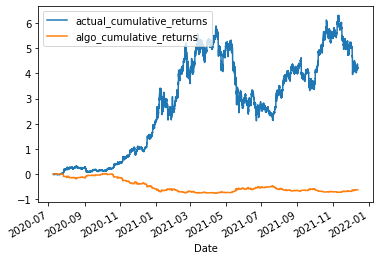

In [39]:
predictions_df[["actual_cumulative_returns","algo_cumulative_returns"]].plot()